In [1]:
#To autoreload a function if it is changed
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import anndata
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os



from utils import plot_histogram
from var import sc_data_folder, results_folder, today, color

In [3]:
#set seed to 1 for reproducibility of results
np.random.seed(0)


In [18]:
#Create figures folder
figures_folder = os.path.join(results_folder, 'figures/rna_exploration/')
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

<h3> 1. Load .h5ad and mapping file </h3>

In [4]:
def read_10x_output(file_path, smp_list, metadata=None, type = 'raw', umi_filter=5):
    import os
    
    #Writing output from separate samples, processed using CellRanger, into a dictionary of Scanpy objects:
    ad = {}

    #Generate AnnData for each sample
    for sample_name in smp_list:
        path = file_path + sample_name
        for i in os.listdir(path):
            if type in i and 'h5' in i:
                file = i
        ad[sample_name] = sc.read_10x_h5(file_path + sample_name +'/'+file)
        ad[sample_name].var.rename(columns = {'gene_ids':'ENSEMBL'}, inplace = True)
        ad[sample_name].var['SYMBOL'] = ad[sample_name].var.index
        ad[sample_name].var.index = ad[sample_name].var['ENSEMBL']
        ad[sample_name].var.drop(columns=['ENSEMBL'], inplace=True)
        #ad[sample_name].var_names_make_unique() 
        
        
        sc.pp.calculate_qc_metrics(ad[sample_name], inplace=True)
        ad[sample_name] = ad[sample_name][ad[sample_name].obs['total_counts'] > umi_filter, :]
        ad[sample_name].var['mt'] = [gene.startswith('mt-') 
                                     for gene in ad[sample_name].var['SYMBOL']]
        ad[sample_name].obs['mt_frac'] = (ad[sample_name][:, 
               ad[sample_name].var['mt'].tolist()].X.sum(1).A.squeeze() 
                                          / ad[sample_name].obs['total_counts'])
        
        ad[sample_name].obs['sample'] = sample_name
        ad[sample_name].obs['barcode'] = ad[sample_name].obs_names
        ad[sample_name].obs_names = ad[sample_name].obs['sample']+"_"+ad[sample_name].obs['barcode']

    #Merge AnnData objects from all the samples together    
    from scipy.sparse import vstack
    stack = vstack([ad[x].X for x in smp_list]) # stack data
    adata = sc.AnnData(stack, var = ad[smp_list[0]].var)
    adata.obs = pd.concat([ad[x].obs for x in smp_list], axis = 0)

    if metadata is not None:
        #Add cleaned metadata to the Anndata.obs table
        obs_merged = pd.merge(left = adata.obs, right = metadata, 
                              how = "left", left_on="sample", right_on="sample")
        obs_merged.index = obs_merged['sample']+"_"+obs_merged['barcode']
        print(obs_merged.index.equals(adata.obs.index))
        adata.obs = obs_merged

    return adata, ad


In [5]:
#Create a sample list in form of a dataframe to be concatenated by the read_10x_output function
sample_list = pd.DataFrame({
    'sample': ['cellranger710_count_05e682d5679826b9b76d6bec731bbe61']
})

In [6]:


#Read in 10x data in raw and filtered format
adata, ad_list = read_10x_output(
    sc_data_folder, 
    smp_list=sample_list['sample'],
    metadata=sample_list, type = 'raw')
# export aggregated and pre-processed data
# adata.write(f'{results_folder}{today}_all_cells_with_empty.h5ad')

adata, ad_list = read_10x_output(
    sc_data_folder, 
    smp_list=sample_list['sample'],
    metadata=sample_list, type = 'filtered')
# export aggregated and pre-processed data
# adata.write(f'{results_folder}{today}_all_cells.h5ad')

/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_30489/435707439.py:23: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[sample_name].var['mt'] = [gene.startswith('mt-')


True


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_30489/435707439.py:23: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[sample_name].var['mt'] = [gene.startswith('mt-')


True


In [8]:
#Read in sgRNA sequences to count reads per guide
sgrna_df=pd.read_csv(f'{sc_data_folder}cellranger710_count_05e682d5679826b9b76d6bec731bbe61/feature_reference.csv')
#Append additional sgRNA sequences that were not included in the data by appending rows to the dataframe
sgrna_rest_df = pd.DataFrame(
    [[
        "sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_2",
        "sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_2",
        "R2",
        "TGCTGTTTCCAGCATAGCTCTTAAAC(BC)",
        "AGTCGCGATCGAACACTCGC",
        "CRISPR Guide Capture"
        ],
    [
        "sgRNA6_SCP_GCAGACGTGCCTACGGACCG_sgRNA6_SCP_GCAGACGTGCCTACGGACCG_2",
        "sgRNA6_SCP_GCAGACGTGCCTACGGACCG_sgRNA6_SCP_GCAGACGTGCCTACGGACCG_2",
        "R2",
        "TGCTGTTTCCAGCATAGCTCTTAAAC(BC)",
        "CGGTCCGTAGGCACGTCTGC",
        "CRISPR Guide Capture"]],
    columns= sgrna_df.columns
)
#rowwise concatenation of the two dataframes
sgrna_df = pd.concat([sgrna_df, sgrna_rest_df], axis=0,ignore_index=True)

<h3> 2. Data exploration by visualisation</h3>

<h4> 2.1 Exploration of .h5ad file</h4>

In [9]:
def subset_cells(
    adata,
    cells_per_category=10000,
    stratify_category_key='sample',
):
    
    adata.obs['_cell_index'] = np.arange(adata.n_obs)
    subset_ind = list()
    
    for ct in adata.obs[stratify_category_key].unique():
        ind = adata.obs[stratify_category_key] == ct
        subset_ind_ = adata.obs['_cell_index'][ind]
        n_samples = np.min((len(subset_ind_), cells_per_category))
        subset_ind = subset_ind + list(np.random.choice(subset_ind_, size=n_samples, replace=False))
    print(len(subset_ind))
    
    return adata[subset_ind, :].copy()

def compute_pcs_knn_umap(
    adata_subset, stratify_category_key='sample', 
    tech_category_key=None, plot_category_keys=list(), 
    scale_max_value=10, n_comps=100, n_neighbors=15,
):
    adata_subset.obs['total_counts'] = np.array(adata_subset.X.sum(1)).flatten()
    adata_subset.layers['counts'] = adata_subset.X.copy()
    # No normalisation by total count
    sc.pp.log1p(adata_subset)
    # Scale with no HVG selection
    if tech_category_key is None:
        sc.pp.scale(adata_subset, max_value=scale_max_value)
    else:
        for tech in adata_subset.obs[tech_category_key].unique():
            mu, std = compute_mu_std(adata_subset[adata_subset.obs[tech_category_key] == tech].X)
            adata_subset[adata_subset.obs[tech_category_key] == tech].X = (
                np.minimum((adata_subset[adata_subset.obs[tech_category_key] == tech].X - mu) / std, scale_max_value)
            )
    # A lot of PC dimensions
    sc.tl.pca(adata_subset, svd_solver='arpack', n_comps=n_comps, use_highly_variable=False)
    # Plot PCs to confirm that PC1 is indeed linked to total count
    # sc.pl.pca(adata_subset, color=['total_counts'],
    #           components=['1,2', '2,3', '4,5'],
    #           color_map = 'RdPu', ncols = 3, legend_loc='on data',
    #           legend_fontsize=10)
    plt.hist2d(adata_subset.obsm['X_pca'][:, 0].flatten(),
               adata_subset.obs['total_counts'].values.flatten(),
               bins=200,
               norm=mpl.colors.LogNorm());
    plt.xlabel('PC 1');
    plt.ylabel('Total RNA count');
    plt.show()
    plt.savefig(f'{results_folder}{today}_hist2d.pdf')

    # Remove PC1
    adata_subset.obsm['X_pca'] = adata_subset.obsm['X_pca'][:, 1:]
    adata_subset.varm['PCs'] = adata_subset.varm['PCs'][:, 1:]

    # compute KNN and UMAP to see how well this represents the dataset
    sc.pp.neighbors(adata_subset, n_neighbors=n_neighbors)
    sc.tl.umap(adata_subset, min_dist = 0.4, spread = 1.5)

    # Plot UMAP
    sc.pl.umap(adata_subset, color=[stratify_category_key],
               color_map = 'RdPu', ncols = 3, #legend_loc='on data',
               legend_fontsize=10)
    return adata_subset

def compute_mu_std(X):
        
    mu = np.array(X.mean(0))
    mu_sq = mu ** 2
    X = X.copy()
    X.data = X.data ** 2
    sq_mu = np.array(X.mean(0))
    std = np.sqrt(sq_mu - mu_sq) + 1e-8
    
    return mu, std

In [10]:
cells_per_category=20000
stratify_category_key='sample'
tech_category_key=None


adata_subset = subset_cells(
    adata, cells_per_category=cells_per_category, 
    stratify_category_key=stratify_category_key,
)

12797


Global seed set to 0
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


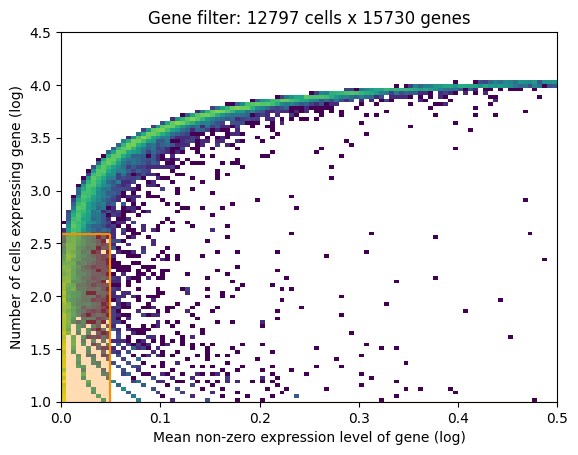

In [11]:
# select informative genes but keep all barcodes
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_subset, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
plt.show()

#find target transcription factors to keep 
#use reference list with all transcription factors
targeted_tfs=sgrna_df['id'].str.split('_').str[0].values
#check if TFs are in the gene names
targeted_tfs_ensembl = list(adata_subset.var_names[adata_subset.var['SYMBOL'].isin(targeted_tfs)])

#find transcription factors 
targeted_tfs=sgrna_df['id'].str.split('_').str[0].values
targeted_tfs_ensembl = list(adata_subset.var_names[adata_subset.var['SYMBOL'].isin(targeted_tfs)])

adata_subset = adata_subset[:, np.unique(list(selected) + targeted_tfs_ensembl)].copy()

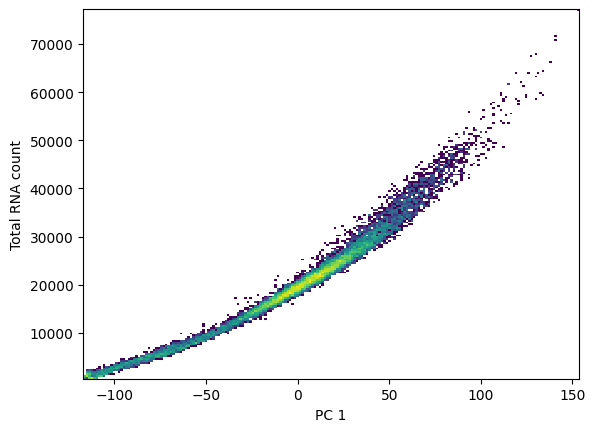

TypeError: can only concatenate list (not "NoneType") to list

In [12]:
### Step 1.1 - compute PCs by apply standard workflow with a few exceptions ##
adata_subset = compute_pcs_knn_umap(
    adata_subset, 
    tech_category_key=None, plot_category_keys=None, 
    scale_max_value=10, n_comps=50, n_neighbors=15,
)

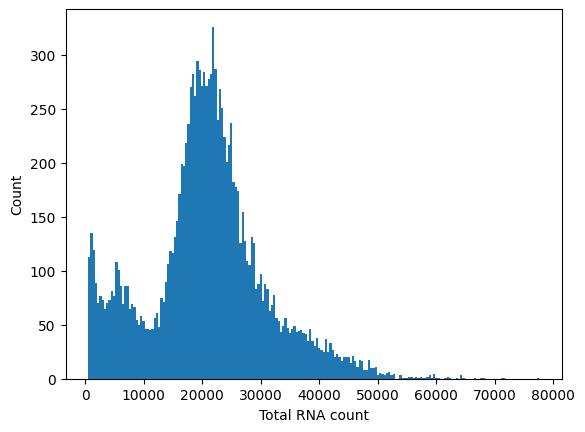

<Figure size 640x480 with 0 Axes>

In [16]:
plot_histogram(
    adata_subset.obs, 
    'total_counts', 
    num_bins=200, 
    xlabel='Total RNA count', ylabel='Count',
    results_folder=f'{figures_folder}',
    today=today,
    figname='total_rna_count'
    )

In [17]:
# Leiden clustering
sc.tl.leiden(adata_subset, resolution=2)

KeyError: 'No "neighbors" in .uns'

In [ ]:
#look at differentially expressed genes 